[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aymgal/herculens_workspace/blob/main/notebooks/herculens__Complex_source_and_point_source_modeling.ipynb)

# Modeling a lensed quasar and its host with `Herculens`

This notebooks shows a similar example as in the [Starting guide notebook](https://github.com/aymgal/herculens_workspace/blob/main/notebooks/herculens__Starting_guide.ipynb), but with a more complex source that requires a more flexible model (wavelets) and a lensed point source that mimics a quasar. We don't include any light from the lens in this notebook.

__authors__: @aymgal, @austinpeel

__last update__: 07/12/23

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Installing requirements and dependencies
    !pip install --quiet git+https://github.com/austinpeel/herculens.git
    !pip install --quiet git+https://github.com/aymgal/utax.git
    !pip install --quiet optax blackjax-nightly numpyro
    !pip install --quiet arviz corner

In [2]:
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm, Normalize, TwoSlopeNorm
plt.rc('image', interpolation='none')

# Basic imports
import os
import numpy as np
from copy import deepcopy
import time
from functools import partial
import corner
from pprint import pprint

# JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)  # uncomment for double precision
if IN_COLAB:
    _ = jnp.zeros(10)  # allocate the GPU memory
    #os.environ['JAX_JIT_PJIT_API_MERGE'] = '0'  # temporary fix bug with latest JAX version (https://github.com/pyro-ppl/numpyro/issues/1542)

# NUTS Hamiltonian MC sampling
import blackjax

# probabilistic model
import numpyro
import numpyro.distributions as dist
from numpyro.distributions import constraints

# variational inference
import optax  # optimizers
from numpyro.infer import Predictive, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal, AutoBNAFNormal

# Herculens
from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.Instrument.noise import Noise
from herculens.LightModel.light_model import LightModel
from herculens.MassModel.mass_model import MassModel
from herculens.PointSourceModel.point_source_model import PointSourceModel
from herculens.LensImage.lens_image import LensImage
from herculens.RegulModel.regul_model import RegularizationModel
from herculens.Inference.loss import Loss
from herculens.Inference.ProbModel.numpyro import NumpyroModel
from herculens.Inference.Optimization.jaxopt import JaxoptOptimizer
from herculens.Inference.Optimization.optax import OptaxOptimizer
from herculens.Analysis.plot import Plotter
from herculens.Util import image_util, param_util, plot_util

# import ipywidgets

## Simulate an observation of strong lens

### Define the coordinates grid

In [3]:
npix = 80  # number of pixel on a side
pix_scl = 0.08  # pixel size in arcsec
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2  # position of the (0, 0) with respect to bottom left pixel
transform_pix2angle = pix_scl * np.eye(2)  # transformation matrix pixel <-> angle
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}

# create the PixelGrid class
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (80, 80) pixels
pixel size : 0.08 arcsec
x range    : (-3.16, 3.16) arcsec
y range    : (-3.16, 3.16) arcsec


### Setup point spread function (PSF) and observation/noise properties

For simplicity we assume a Gaussian PSF but you can also provide an image of the PSF via `psy_type='PIXELATED'`

In [4]:
psf = PSF(psf_type='GAUSSIAN', fwhm=0.3, pixel_size=pixel_grid.pixel_width)

noise = Noise(npix, npix, background_rms=1e-2, exposure_time=1000.)

### Lens galaxy + source galaxy

We assume a SIE embedded in an external shear

In [5]:
# Lens mass
lens_mass_model_input = MassModel(['SIE', 'SHEAR'])

# position of the lens
cx0, cy0 = 0., 0.
# position angle, here in degree
phi = 8.0
# axis ratio, b/a
q = 0.75
# conversion to ellipticities
e1, e2 = param_util.phi_q2_ellipticity(phi * np.pi / 180, q)
# external shear orientation, here in degree
phi_ext = 54.0
# external shear strength
gamma_ext = 0.03
# conversion to polar coordinates
gamma1, gamma2 = param_util.shear_polar2cartesian(phi_ext * np.pi / 180, gamma_ext)
# print(e1, e2)
# print(gamma1, gamma2)
kwargs_lens_input = [
    {'theta_E': 1.5, 'e1': e1, 'e2': e2, 'center_x': cx0, 'center_y': cy0},  # SIE
    {'gamma1': gamma1, 'gamma2': gamma2, 'ra_0': 0.0, 'dec_0': 0.0}  # external shear
]
pprint(kwargs_lens_input)

# Source light
source_model_input = LightModel(['SERSIC_ELLIPSE', 'GAUSSIAN'])
beta_true = [0.05, 0.1]
kwargs_source_input = [
    {'amp': 10.0, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': 0.05, 'e2': 0.05, 'center_x': beta_true[0], 'center_y': beta_true[1]},
    {'amp': 1., 'sigma': 0.05, 'center_x': beta_true[0] + 0.25, 'center_y': beta_true[1] + 0.2} # add a bit of complexity in the source galaxy
]

[{'center_x': 0.0,
  'center_y': 0.0,
  'e1': Array(0.1373231, dtype=float64, weak_type=True),
  'e2': Array(0.03937677, dtype=float64, weak_type=True),
  'theta_E': 1.5},
 {'dec_0': 0.0,
  'gamma1': Array(-0.00927051, dtype=float64, weak_type=True),
  'gamma2': Array(0.0285317, dtype=float64, weak_type=True),
  'ra_0': 0.0}]


### Point Source

In [6]:
# Create a pixel grid for solving the lens equation
ps_grid_npix = 2 * npix + 1
ps_grid_pix_scl = (pix_scl * npix) / ps_grid_npix
ps_grid_half_size = ps_grid_npix * ps_grid_pix_scl / 2.
ps_grid_ra_at_xy_0 = ps_grid_dec_at_xy_0 = -ps_grid_half_size + ps_grid_pix_scl / 2.
ps_grid_transform_pix2angle = ps_grid_pix_scl * np.eye(2)
kwargs_ps_grid = {'nx': ps_grid_npix, 'ny': ps_grid_npix,
                  'ra_at_xy_0': ps_grid_ra_at_xy_0, 'dec_at_xy_0': ps_grid_dec_at_xy_0,
                  'transform_pix2angle': ps_grid_transform_pix2angle}
ps_grid = PixelGrid(**kwargs_ps_grid)

point_source_type_list = ['SOURCE_POSITION']
point_source_model_input = PointSourceModel(point_source_type_list, lens_mass_model_input, ps_grid)

kwargs_ps = {'ra': beta_true[0], 'dec': beta_true[1], 'amp': 2.}
kwargs_point_source_input = [kwargs_ps]

# Solver hyperparameters
niter_solver = 5
triangle_scale_factor = 2
n_triangle_subdivisions = 3
kwargs_lens_equation_solver = {'nsolutions': 5, 
                               'niter': niter_solver, 
                               'scale_factor': triangle_scale_factor, 
                               'nsubdivisions': n_triangle_subdivisions}

# Point source position accuracy in image plane
ps_accuracy = ps_grid_pix_scl * (triangle_scale_factor / 4**n_triangle_subdivisions)**(niter_solver / 2.)
print(f"PS max error : {ps_accuracy:.4}")

PS max error : 6.862e-06


### Generate the lens image

In [7]:
# Generate a lensed image based on source and lens models
kwargs_numerics_simu = {'supersampling_factor': 5}
lens_image_simu = LensImage(pixel_grid, psf, noise_class=noise,
                         lens_mass_model_class=lens_mass_model_input,
                         source_model_class=source_model_input,
                         point_source_model_class=point_source_model_input,
                         kwargs_numerics=kwargs_numerics_simu,
                         kwargs_lens_equation_solver=kwargs_lens_equation_solver)

kwargs_all_input = dict(kwargs_lens=kwargs_lens_input,
                        kwargs_source=kwargs_source_input,
                        kwargs_point_source=kwargs_point_source_input)

# clean image (no noise)
image = lens_image_simu.model(**kwargs_all_input)

# simulated observation including noise
data = lens_image_simu.simulation(**kwargs_all_input, compute_true_noise_map=True, noise_seed=42)

In [8]:
# Plotting engine
plotter = Plotter(flux_vmin=8e-3, flux_vmax=6e-1)

# inform the plotter of the data and, if any, the true source 
plotter.set_data(data)

source_input = lens_image_simu.source_surface_brightness(kwargs_source_input, de_lensed=True, unconvolved=True)
plotter.set_ref_source(source_input)

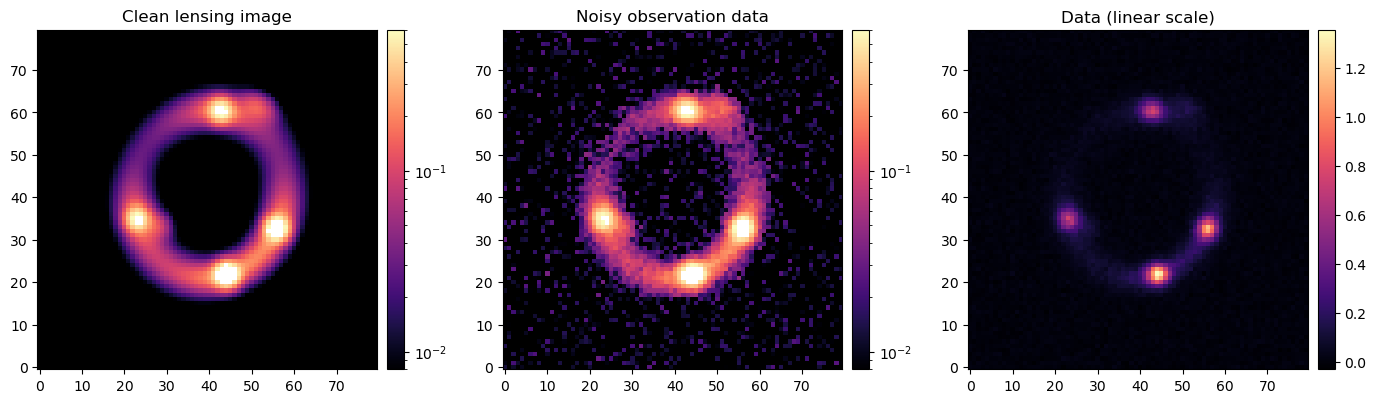

In [9]:
# visualize simulated products
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
img1 = ax1.imshow(image, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(img1)
ax1.set_title("Clean lensing image")
img2 = ax2.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
ax2.set_title("Noisy observation data")
plot_util.nice_colorbar(img2)
img3 = ax3.imshow(data, origin='lower', cmap=plotter.cmap_flux)
ax3.set_title("Data (linear scale)")
plot_util.nice_colorbar(img3)
fig.tight_layout()
plt.show()

## Fit the image with a fully smooth model

For this example we assume the same models as in the simulated data.

In [10]:
kwargs_numerics_fit = {'supersampling_factor': 3}
kwargs_lens_equation_solver_model = {'nsolutions': 5, 'niter': 5, 'scale_factor': 2, 'nsubdivisions': 3}
lens_image = LensImage(deepcopy(pixel_grid), deepcopy(psf), noise_class=deepcopy(noise),
                         lens_mass_model_class=deepcopy(lens_mass_model_input),
                         source_model_class=LightModel(['SERSIC_ELLIPSE']),
                         point_source_model_class=deepcopy(point_source_model_input),
                         kwargs_numerics=kwargs_numerics_fit,
                         kwargs_lens_equation_solver=kwargs_lens_equation_solver_model)

In [11]:
class ProbModel(NumpyroModel):
    
    def model(self):
        # Parameters of the point source
        ps_x0 = kwargs_source_input[0]['center_x']
        ps_y0 = kwargs_source_input[0]['center_y']
        
        ps_x = numpyro.sample('ps_center_x', dist.Normal(ps_x0, pix_scl/2.))
        ps_y = numpyro.sample('ps_center_y', dist.Normal(ps_y0, pix_scl/2.))
        
        prior_point_source = [{
            'ra': ps_x, 
            'dec': ps_y,
            'amp': numpyro.sample('ps_amp', dist.LogNormal(np.log(kwargs_ps['amp']), 0.1))
        }]
        
        # Parameters of the source
        src_amp0 = kwargs_source_input[0]['amp']
        src_rSersic0 = kwargs_source_input[0]['R_sersic']
        src_nSersic0 = kwargs_source_input[0]['n_sersic']
        src_e10 = kwargs_source_input[0]['e1']
        src_e20 = kwargs_source_input[0]['e2']
#         src_x0 = kwargs_source_input[0]['center_x']
#         src_y0 = kwargs_source_input[0]['center_y']
        
#         src_x = numpyro.sample('source_center_x', dist.Normal(src_x0, 0.02))
#         src_y = numpyro.sample('source_center_y', dist.Normal(src_y0, 0.02))
        
        prior_source = [{
            'amp': numpyro.sample('source_amp', dist.LogNormal(np.log(src_amp0), 0.1)),
            'R_sersic': numpyro.sample('source_R_sersic', dist.TruncatedNormal(src_rSersic0, 0.1, low=0.05)), 
            'n_sersic': numpyro.sample('source_n', dist.Uniform(1., 3.)), 
            'e1': numpyro.sample('source_e1', dist.TruncatedNormal(src_e10, 0.05, low=-0.3, high=0.3)),
            'e2': numpyro.sample('source_e2', dist.TruncatedNormal(src_e20, 0.05, low=-0.3, high=0.3)),
            'center_x': ps_x, 
            'center_y': ps_y
        }]

        # Parameters of the lens
        lens_x0 = kwargs_lens_input[0]['center_x']
        lens_y0 = kwargs_lens_input[0]['center_y']
        
        lens_x = numpyro.sample('lens_center_x', dist.Normal(lens_x0, pix_scl/2.))
        lens_y = numpyro.sample('lens_center_y', dist.Normal(lens_y0, pix_scl/2.))        
        lens_thetaE = kwargs_lens_input[0]['theta_E']
        lens_e10 = kwargs_lens_input[0]['e1']
        lens_e20 = kwargs_lens_input[0]['e2']
        lens_gamma1 = kwargs_lens_input[1]['gamma1']
        lens_gamma2 = kwargs_lens_input[1]['gamma2']

        prior_lens = [{
        # power-law    
            'theta_E': numpyro.sample('lens_theta_E', dist.Normal(lens_thetaE, 0.1)),
            'e1': numpyro.sample('lens_e1', dist.TruncatedNormal(lens_e10, 0.05, low=-0.3, high=0.3)),
            'e2': numpyro.sample('lens_e2', dist.TruncatedNormal(lens_e20, 0.05, low=-0.3, high=0.3)),
            'center_x': lens_x, 
            'center_y': lens_y
        },
        # external shear, with fixed origin
        {
            'gamma1': numpyro.sample('lens_gamma1', dist.TruncatedNormal(lens_gamma1, 0.05, low=-0.3, high=0.3)), 
            'gamma2': numpyro.sample('lens_gamma2', dist.TruncatedNormal(lens_gamma2, 0.05, low=-0.3, high=0.3)), 
            'ra_0': 0.0,
            'dec_0': 0.0
        }]
        
        # wrap up all parameters for the lens_image.model() method
        model_params = dict(kwargs_lens=prior_lens, 
                            kwargs_source=prior_source,
                            kwargs_point_source=prior_point_source)
        
        # generates the model image
        model_image = lens_image.model(**model_params)
        
        # estimate the error per pixel
        model_var = noise.C_D_model(model_image)
        model_std = jnp.sqrt(model_var)
        
        # finally defines the observed node, conditioned on the data assuming a Gaussian distribution
        numpyro.sample('obs', dist.Independent(dist.Normal(model_image, model_std), 2), obs=data)
    
    def params2kwargs(self, params):
        # functions that takes the flattended dictionary of numpyro parameters
        # and reshape it back to the argument of lens_image.model()
        kw = {
        'kwargs_lens': [{'theta_E': params['lens_theta_E'],
                         'e1': params['lens_e1'],
                         'e2': params['lens_e2'],
                         'center_x': params['lens_center_x'],
                         'center_y': params['lens_center_y']},
                        {'gamma1': params['lens_gamma1'],
                         'gamma2': params['lens_gamma2'],
                          'ra_0': 0.0,
                          'dec_0': 0.0}],
        'kwargs_source': [{'amp': params['source_amp'],
                           'R_sersic': params['source_R_sersic'],
                           'n_sersic': params['source_n'],
                           'e1': params['source_e1'],
                           'e2': params['source_e2'],
                           'center_x': params['ps_center_x'],
                           'center_y': params['ps_center_y']}],
        'kwargs_point_source': [{'ra': params['ps_center_x'], 
                                 'dec': params['ps_center_y'], 
                                 'amp': params['ps_amp']}]}
        return kw

prob_model = ProbModel()
n_param = prob_model.num_parameters
print("Number of parameters:", n_param)


Number of parameters: 15


In [12]:
# visualize the probabilistic graph thanks to NumPyro utility
# prob_model.render_model()

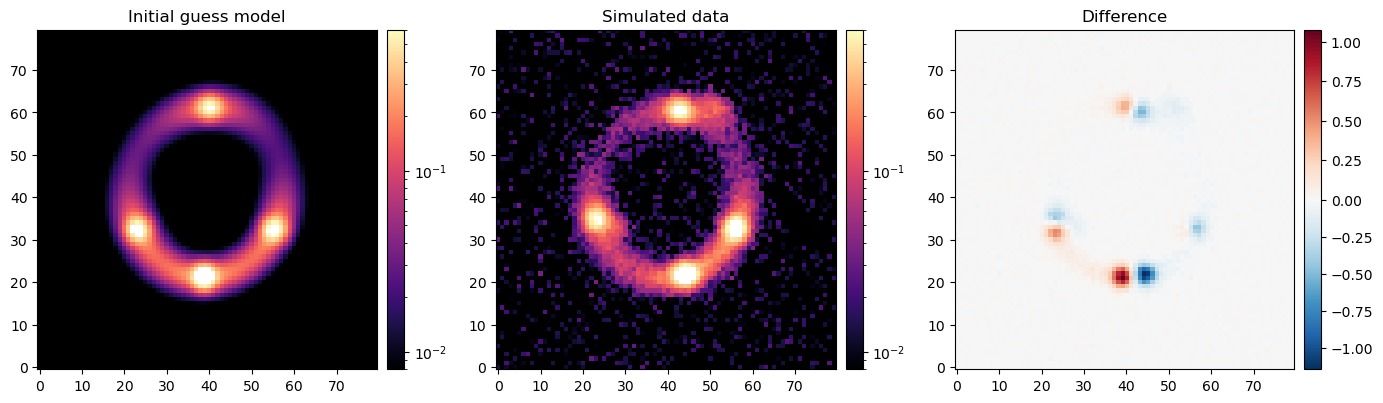

In [13]:
# init_params = prob_model.get_sample(seed=212)  # constrained space
init_params = ({
#  'source_center_x': kwargs_source_input[0]['center_x'] - 0.02,
#  'source_center_y': kwargs_source_input[0]['center_y'] + 0.03,
 'source_amp': kwargs_source_input[0]['amp'],
 'source_R_sersic': kwargs_source_input[0]['R_sersic'],
 'source_n': kwargs_source_input[0]['n_sersic'],
 'source_e1': kwargs_source_input[0]['e1'],
 'source_e2': kwargs_source_input[0]['e2'],
 'lens_center_x': kwargs_lens_input[0]['center_x'],
 'lens_center_y': kwargs_lens_input[0]['center_y'],
 'lens_theta_E': kwargs_lens_input[0]['theta_E'] + 0.02,
 'lens_e1': kwargs_lens_input[0]['e1'],
 'lens_e2': kwargs_lens_input[0]['e2'],
 'lens_gamma1': kwargs_lens_input[1]['gamma1'],
 'lens_gamma2': kwargs_lens_input[1]['gamma2'],
 'ps_center_x': kwargs_source_input[0]['center_x'] - 0.05,
 'ps_center_y': kwargs_source_input[0]['center_y'] + 0.03,
 'ps_amp': kwargs_ps['amp'] - 0.3,
})

# visualize initial guess
init_params_unconst = prob_model.unconstrain(init_params)  # UNconstrained space
kwargs_init = prob_model.params2kwargs(init_params)  # constrained space
initial_model = lens_image.model(**kwargs_init)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
ax = axes[0]
ax.set_title("Initial guess model")
im = ax.imshow(initial_model, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[1]
ax.set_title("Simulated data")
im = ax.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[2]
ax.set_title("Difference")
im = ax.imshow(initial_model - data, origin='lower', norm=TwoSlopeNorm(0), cmap=plotter.cmap_res)
plot_util.nice_colorbar(im)
fig.tight_layout()
plt.show()

In [14]:
loss = Loss(prob_model)
print("Initial loss =", loss(init_params_unconst))
#print("Initial gradient =", loss.gradient(init_params_unconst))

Initial loss = 16202.673677116021


In [15]:
optimizer = JaxoptOptimizer(loss, loss_norm_optim=data.size)  # loss_norm_optim is to reduce loss magnitude
# best_fit_unconst, logL_best_fit, extra_fields, runtime \
#     = optimizer.run_scipy(init_params_unconst, method='BFGS', maxiter=600)
best_fit_unconst, logL_best_fit, extra_fields, runtime \
    = optimizer.run_scipy(init_params_unconst, method='L-BFGS-B', maxiter=200)
print("Runtime:", runtime)

Runtime: 10.36081576347351


Final loss = -19291.444309681454


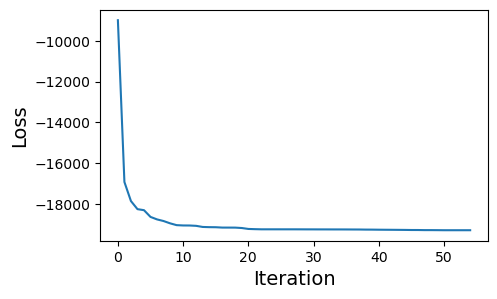

In [16]:
print("Final loss =", loss(best_fit_unconst))

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
ax.set_ylabel("Loss", fontsize=14)
ax.set_xlabel("Iteration", fontsize=14)
plt.show()

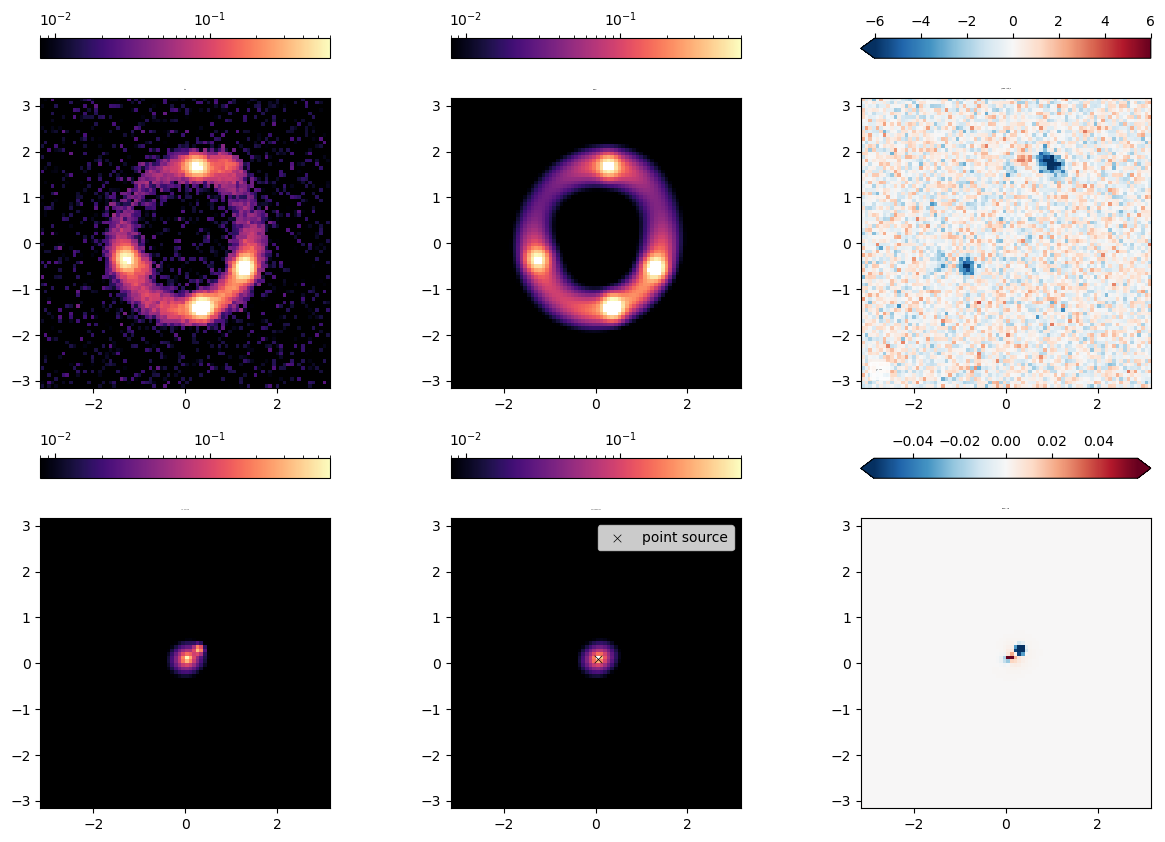

In [17]:
# the best-fit values are in unconstrained space so we transform them here
best_fit = prob_model.constrain(best_fit_unconst)
kwargs_best_fit = deepcopy(prob_model.params2kwargs(best_fit))

fig = plotter.model_summary(lens_image, kwargs_best_fit, show_source=True, 
                            kwargs_grid_source=dict(pixel_scale_factor=1))

In [18]:
# print resulting parameters
print("BEST-FIT VALUES:")
pprint(kwargs_best_fit['kwargs_point_source'])

print("="*80)

# compare to input values
print("INPUT VALUES:")
pprint(kwargs_all_input['kwargs_point_source'])

BEST-FIT VALUES:
[{'amp': Array(1.98498177, dtype=float64),
  'dec': Array(0.10389237, dtype=float64),
  'ra': Array(0.06079265, dtype=float64)}]
INPUT VALUES:
[{'amp': 2.0, 'dec': 0.1, 'ra': 0.05}]


### Switching to a pixelated source model

In [19]:
# choose the source plane resolution, position and size
kwargs_pixelated_source = {
    'pixel_scale_factor': 0.23,
    'grid_center': (kwargs_best_fit['kwargs_source'][0]['center_x'], 
                    kwargs_best_fit['kwargs_source'][0]['center_y']), 
    'grid_shape': (1, 1), # arcsec
}
source_model_pixelated = LightModel(['PIXELATED'], kwargs_pixelated=kwargs_pixelated_source)

# Setup a new LensImage instance
lens_image_pix = LensImage(deepcopy(pixel_grid), deepcopy(psf), noise_class=deepcopy(noise),
                           lens_mass_model_class=deepcopy(lens_mass_model_input),
                           source_model_class=source_model_pixelated,
                           point_source_model_class=deepcopy(point_source_model_input),
                           kwargs_numerics=kwargs_numerics_fit,
                           kwargs_lens_equation_solver=kwargs_lens_equation_solver_model)

# let's retrieve a version of the previous source evaluated on the new source plane
nx_src, ny_src = lens_image_pix.SourceModel.pixel_grid.num_pixel_axes
print("Num. source pixels:", nx_src, ny_src)
x_src, y_src = lens_image_pix.SourceModel.pixel_grid.pixel_coordinates
init_source_pixels = lens_image.SourceModel.surface_brightness(x_src, y_src, kwargs_best_fit['kwargs_source']) * lens_image.Grid.pixel_area

Num. source pixels: 54 54


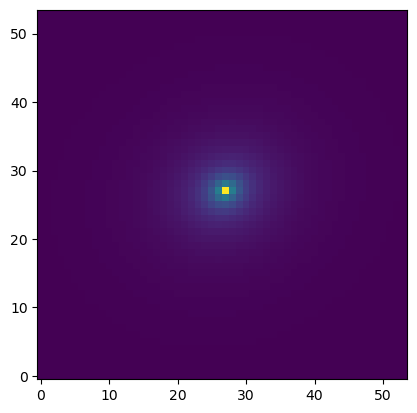

In [20]:
fig, ax = plt.subplots(1, 1)
ax.imshow(init_source_pixels)

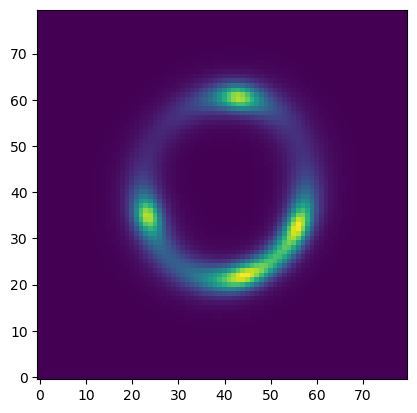

In [21]:
# define how to regularize source pixels
regul_model = RegularizationModel(
    [
        ('source', 0, 'SPARSITY_STARLET'),
        ('source', 0, 'SPARSITY_BLWAVELET'), 
        # ('source', 0, 'POSITIVITY'),
    ]
)

# initialize the weights based on the previous best fit model
# takes a bit of time, as it samples and propagates noise realizations
noise_var = lens_image.Noise.C_D_model(lens_image.model(point_source_add=False, **kwargs_best_fit), force_recompute=True)
fig, ax = plt.subplots(1, 1)
ax.imshow(noise_var)
plt.show()

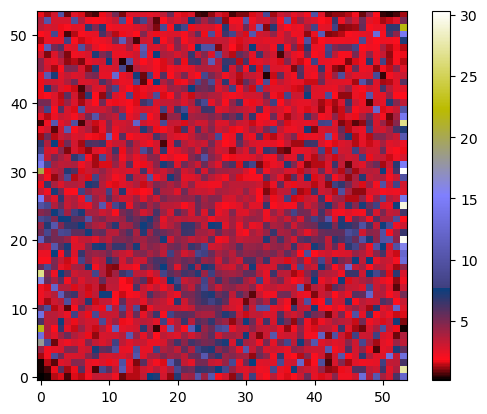

In [22]:
regul_model.initialize(lens_image_pix, kwargs_best_fit, noise_var=noise_var, num_samples=5000)

# visualize the computed weights
weights_list = regul_model.get_weights()

plt.imshow(weights_list[0][0], origin='lower', #norm=LogNorm(), 
           cmap='gist_stern')
plt.colorbar()
plt.show()

In [23]:
class ProbModelPixSource(NumpyroModel):
    
    def model(self):
        # Parameters of the source
        source_pixels = numpyro.param('source_pixels', 
                                      init_value=init_source_pixels, 
                                      event_dim=init_source_pixels.shape,
                                      constraint=constraints.greater_than(0.),
                                      )
        prior_source = [{'pixels': source_pixels}]

        # Parameters of the lens
        prior_lens = [
        # power-law
        {
            'theta_E': numpyro.sample('lens_theta_E', dist.Normal(best_fit['lens_theta_E'], 0.03)),
         'e1': numpyro.sample('lens_e1', dist.TruncatedNormal(best_fit['lens_e1'], 0.05, low=-0.3, high=0.3)),
         'e2': numpyro.sample('lens_e2', dist.TruncatedNormal(best_fit['lens_e2'], 0.05, low=-0.3, high=0.3)),
         'center_x': numpyro.sample('lens_center_x', dist.Normal(best_fit['lens_center_x'], pix_scl/2.)), 
         'center_y': numpyro.sample('lens_center_y', dist.Normal(best_fit['lens_center_y'], pix_scl/2.))},
        # external shear, with fixed origin
        {'gamma1': numpyro.sample('lens_gamma1', dist.TruncatedNormal(best_fit['lens_gamma1'], 0.05, low=-0.3, high=0.3)), 
         'gamma2': numpyro.sample('lens_gamma2', dist.TruncatedNormal(best_fit['lens_gamma2'], 0.05, low=-0.3, high=0.3)), 
         'ra_0': 0.0, 'dec_0': 0.0}
        ]
        
        # Parameters of the point source
        ps_x = numpyro.sample('ps_center_x', dist.Normal(best_fit['ps_center_x'], pix_scl/2.))
        ps_y = numpyro.sample('ps_center_y', dist.Normal(best_fit['ps_center_y'], pix_scl/2.))
        ps_amp = numpyro.sample('ps_amp', dist.LogNormal(np.log(best_fit['ps_amp']), 0.1))
        # ps_x = best_fit['ps_center_x']
        # ps_y = best_fit['ps_center_y']
        # ps_amp = best_fit['ps_amp']
        prior_point_source = [{
            'ra': ps_x,
            'dec': ps_y,
            'amp': ps_amp
        }]
        
        # wrap up all parameters for the lens_image.model() method
        model_params = dict(kwargs_lens=prior_lens, 
                            kwargs_source=prior_source,
                            kwargs_point_source=prior_point_source)
        
        # generates the model image
        model_image = lens_image_pix.model(**model_params)
        
        # estimate the error per pixel
        model_var = lens_image_pix.Noise.C_D_model(model_image)
        model_std = jnp.sqrt(model_var)
        
        # finally defines the observed node, conditioned on the data assuming a Gaussian distribution
        numpyro.sample('obs', dist.Independent(dist.Normal(model_image, model_std), 2), obs=data)

        # factors in regularization log-probability
        hyperparams = [
            # NOTE: we could also optimize / infer these hyperparameters
            {'lambda_0': 3., 'lambda_1': 3.},
            {'lambda_0': 3.},
            # {'strength': 3.},
        ]
        numpyro.factor('source_regul', regul_model.log_prob(model_params, hyperparams))
    
    def params2kwargs(self, params):
        # functions that takes the flattended dictionary of numpyro parameters
        # and reshape it back to the argument of lens_image.model()
        kw = {
        'kwargs_lens': [{'theta_E': params['lens_theta_E'],
                         'e1': params['lens_e1'],
                         'e2': params['lens_e2'],
                         'center_x': params['lens_center_x'],
                         'center_y': params['lens_center_y']},
                        {'gamma1': params['lens_gamma1'],
                         'gamma2': params['lens_gamma2'],
                          'ra_0': 0.0,
                          'dec_0': 0.0}],
        'kwargs_source': [{'pixels': params['source_pixels']}],
        'kwargs_point_source': [
            {
                # 'ra': best_fit['ps_center_x'],
                # 'dec': best_fit['ps_center_y'],
                # 'amp': best_fit['ps_amp'],
                'ra': params['ps_center_x'], 
                'dec': params['ps_center_y'],
                'amp': params['ps_amp'],
            }
        ]
        }
        return kw

prob_model_pix = ProbModelPixSource()
print("Number of parameters:", prob_model_pix.num_parameters)


Number of parameters: 2926


In [24]:
init_params_pix = {k: v for k, v in best_fit.items() if 'lens' in k or 'light' in k or 'ps' in k}
init_params_pix['source_pixels'] = init_source_pixels
pprint(init_params_pix)

{'lens_center_x': Array(0.00911988, dtype=float64),
 'lens_center_y': Array(0.00158818, dtype=float64),
 'lens_e1': Array(0.13414872, dtype=float64),
 'lens_e2': Array(0.04659761, dtype=float64),
 'lens_gamma1': Array(-0.01447874, dtype=float64),
 'lens_gamma2': Array(0.03382016, dtype=float64),
 'lens_theta_E': Array(1.4979453, dtype=float64),
 'ps_amp': Array(1.98498177, dtype=float64),
 'ps_center_x': Array(0.06079265, dtype=float64),
 'ps_center_y': Array(0.10389237, dtype=float64),
 'source_pixels': Array([[0.00274176, 0.00289826, 0.00306034, ..., 0.00220331, 0.00207607,
        0.001955  ],
       [0.0029414 , 0.00311581, 0.00329708, ..., 0.00238231, 0.00224089,
        0.00210668],
       [0.00315291, 0.00334712, 0.00354971, ..., 0.00257554, 0.00241834,
        0.00226955],
       ...,
       [0.00228877, 0.00244421, 0.00260914, ..., 0.00405471, 0.00381857,
        0.00359236],
       [0.00212895, 0.00226955, 0.00241834, ..., 0.00376035, 0.00354971,
        0.00334712],
       [

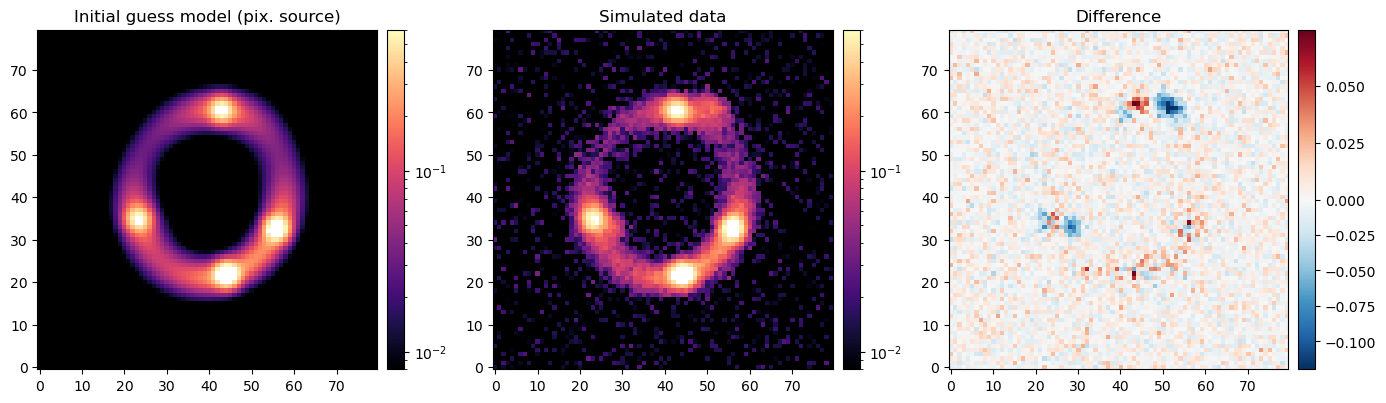

In [25]:

init_params_pix_unconst = prob_model_pix.unconstrain(init_params_pix)  # UNconstrained space
kwargs_init_pix = prob_model_pix.params2kwargs(init_params_pix)  # constrained space

initial_model = lens_image_pix.model(**kwargs_init_pix)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
ax = axes[0]
ax.set_title("Initial guess model (pix. source)")
im = ax.imshow(initial_model, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[1]
ax.set_title("Simulated data")
im = ax.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[2]
ax.set_title("Difference")
im = ax.imshow(initial_model - data, origin='lower', norm=TwoSlopeNorm(0), cmap=plotter.cmap_res)
plot_util.nice_colorbar(im)
fig.tight_layout()
plt.show()

In [26]:
loss_pix = Loss(prob_model_pix)
print("Initial loss =", loss_pix(init_params_pix_unconst))
#print("Initial gradient =", loss.gradient(init_params_unconst))

Initial loss = -18882.111745970098


In [27]:
optimizer_pix = OptaxOptimizer(loss_pix, loss_norm_optim=data.size)

# optimizer setting
init_learning_rate = 1e-3

best_fit_pix_unconst, logL, extra_fields, runtime \
    = optimizer_pix.run(init_params_pix_unconst, max_iterations=410, 
                        stop_at_loss_increase=True,
                        init_learning_rate=init_learning_rate)
print(f"Runtime: {runtime}")
print("Loss at best-fit:", loss_pix(best_fit_pix_unconst))

optax.adabelief: 100%|██████████| 410/410 [00:11<00:00, 34.94it/s]


Runtime: 11.75143814086914
Loss at best-fit: -19413.8533320875


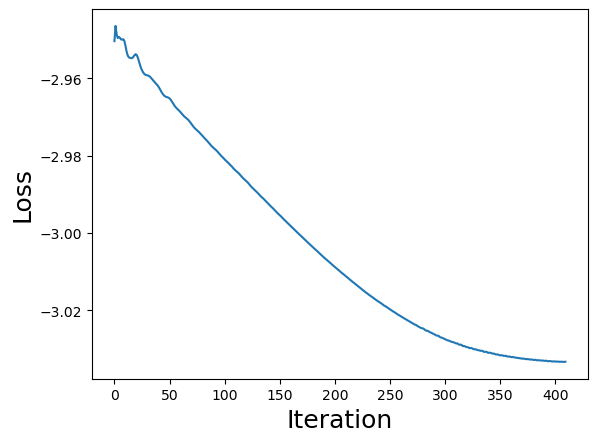

In [28]:
# print("Loss at best-fit:", loss_pix(best_fit_pix_unconst))

fig, ax = plt.subplots(1, 1)
ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
ax.set_ylabel("Loss", fontsize=18)
ax.set_xlabel("Iteration", fontsize=18)
#ax.set_xlim(0, 10)
plt.show()

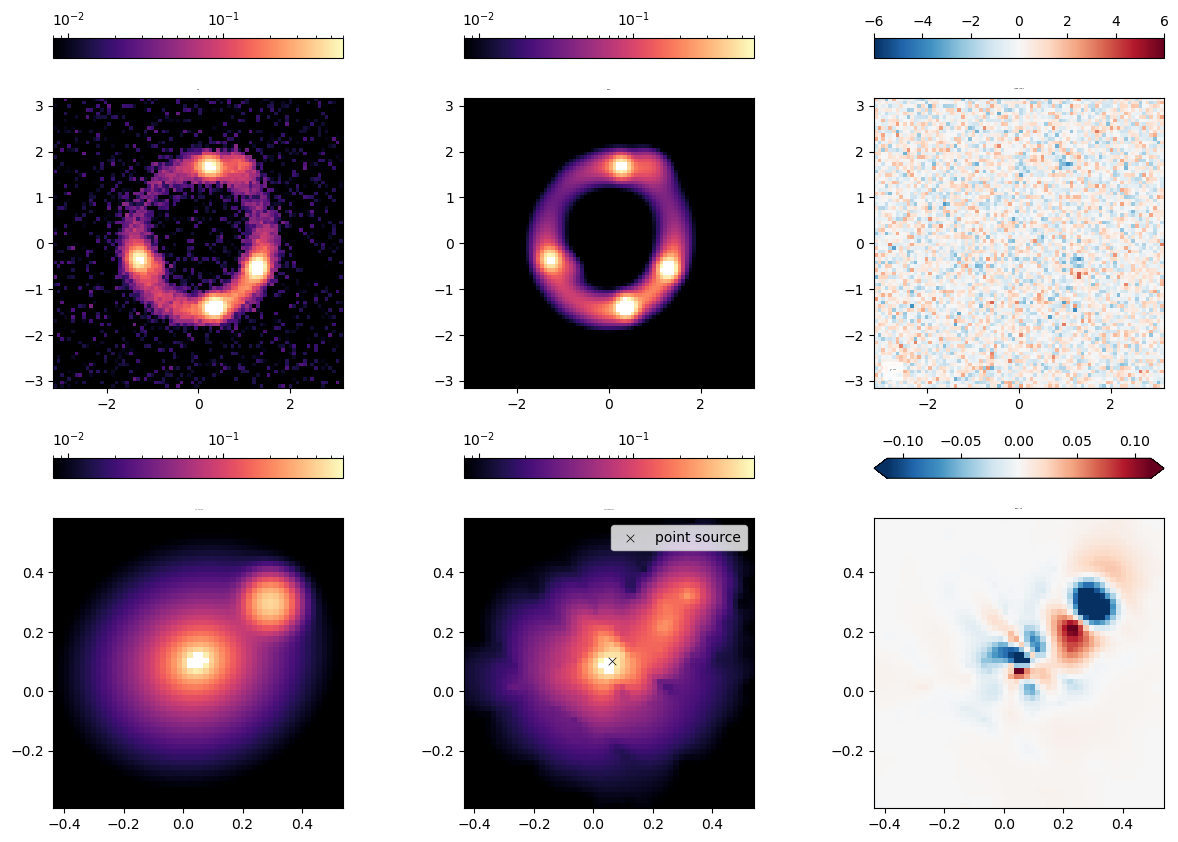

In [29]:
# the best-fit values are in unconstrained space so we transform them here
best_fit_pix = prob_model_pix.constrain(best_fit_pix_unconst)
kwargs_best_fit_pix = prob_model_pix.params2kwargs(best_fit_pix)

# we evaluate the reference 'true' source on the same grid as the input
ref_source_pixels = source_model_input.surface_brightness(x_src, y_src, kwargs_source_input) * lens_image.Grid.pixel_area
plotter.set_ref_source(ref_source_pixels)

fig = plotter.model_summary(lens_image_pix, kwargs_best_fit_pix, show_source=True,
                            kwargs_grid_source=dict(pixel_scale_factor=1))
plt.show()

In [30]:
kwargs_best_fit_pix['kwargs_point_source'], kwargs_best_fit['kwargs_point_source']

([{'ra': Array(0.06079265, dtype=float64),
   'dec': Array(0.10389237, dtype=float64),
   'amp': Array(1.95309482, dtype=float64)}],
 [{'ra': Array(0.06079265, dtype=float64),
   'dec': Array(0.10389237, dtype=float64),
   'amp': Array(1.98498177, dtype=float64)}])